,delay_mean,delay_err,div_mean,div_err,landed_mean,cong_mean,cong_err,scenario
λ,,,,,,,,
0.02,0.243655,0.042650,0.000000,0.000000e+00,0.981548,0.000000,0.000000e+00,Normal
0.10,2.359915,0.081749,0.073709,3.678609e-03,0.901290,0.001666,5.750882e-04,Normal
0.20,3.632703,0.074451,0.313033,4.922897e-03,0.664675,0.002626,4.853803e-04,Normal
0.50,0.759717,0.043726,0.689664,1.785927e-03,0.290452,0.002706,2.617321e-04,Normal
1.00,0.000000,0.000000,0.802778,0.000000e+00,0.166667,0.003704,6.133174e-20,Normal
0.02,0.965808,0.165222,0.000000,0.000000e+00,0.981548,0.000000,0.000000e+00,Tormenta
0.10,3.162086,0.103252,0.080155,4.241284e-03,0.894844,0.001666,5.750882e-04,Tormenta
0.20,4.108770,0.086897,0.329158,4.812501e-03,0.648550,0.002626,4.853803e-04,Tormenta
0.50,0.799276,0.046184,0.698304,1.550527e-03,0.281775,0.002702,2.666243e-04,Tormenta


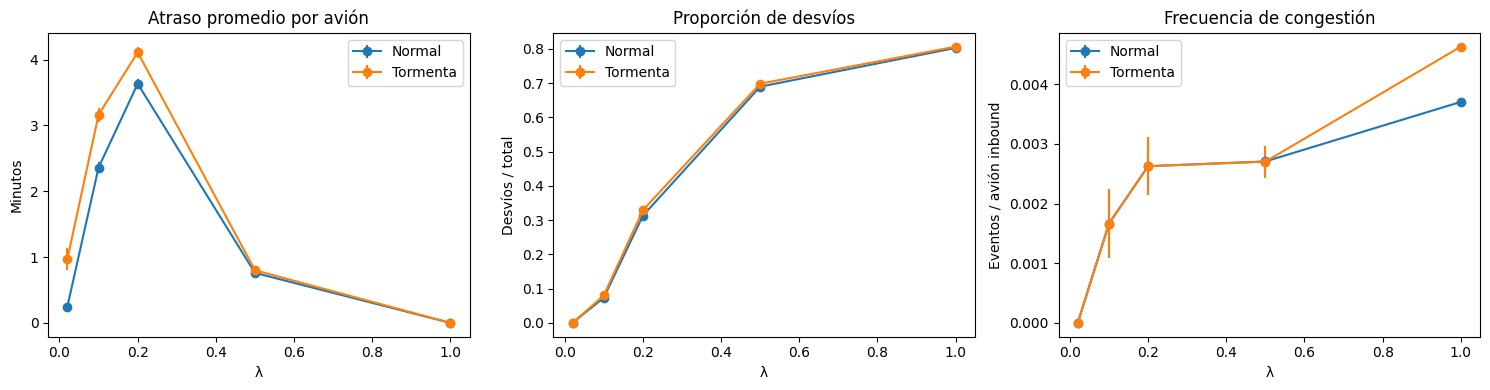

In [8]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from main import SimuladorTormenta, Simulador

# ======================
# Monte Carlo Día Normal
# ======================
def correr_montecarlo_normal(lam, n_rep=50):
    atrasos, desviados, aterrizados, congestiones = [], [], [], []
    for rep in range(n_rep):
        sim = Simulador(seed=rep)
        sim.simular_dia(lam)
        avs = list(sim.aviones.values())

        # atrasos
        atrasos_rep = [a.retraso for a in avs if a.estado == "ATERRIZADO"]
        atrasos.append(np.mean(atrasos_rep) if atrasos_rep else 0)

        # desvíos
        desviados.append(sum(1 for a in avs if a.estado == "DESVIADO") / max(1, len(avs)))

        # aterrizados
        aterrizados.append(sum(1 for a in avs if a.estado == "ATERRIZADO") / max(1, len(avs)))

        # congestión
        congestiones.append(sum(1 for a in avs if a.estado == "AJUSTANDO") / max(1, len(avs)))

    return {
        "delay_mean": np.mean(atrasos),
        "delay_err": np.std(atrasos)/np.sqrt(n_rep),
        "div_mean": np.mean(desviados),
        "div_err": np.std(desviados)/np.sqrt(n_rep),
        "landed_mean": np.mean(aterrizados),
        "cong_mean": np.mean(congestiones),
        "cong_err": np.std(congestiones)/np.sqrt(n_rep)
    }


def correr_montecarlo_tormenta(lam, n_rep=50, t_inicio=600, duracion=30):
    atrasos, desviados, aterrizados, congestiones = [], [], [], []
    for rep in range(n_rep):
        sim = SimuladorTormenta(seed=rep, t_inicio=t_inicio, duracion=duracion)
        sim.simular_dia(lam)
        avs = list(sim.aviones.values())

        # atrasos
        atrasos_rep = [a.retraso for a in avs if a.estado == "ATERRIZADO"]
        atrasos.append(np.mean(atrasos_rep) if atrasos_rep else 0)

        # desvíos
        desviados.append(sum(1 for a in avs if a.estado == "DESVIADO") / max(1, len(avs)))

        # aterrizados
        aterrizados.append(sum(1 for a in avs if a.estado == "ATERRIZADO") / max(1, len(avs)))

        # congestión (proporción de aviones que ajustaron velocidad en algún momento)
        congestiones.append(sum(1 for a in avs if a.estado == "AJUSTANDO") / max(1, len(avs)))

    return {
        "delay_mean": np.mean(atrasos), "delay_err": np.std(atrasos)/np.sqrt(n_rep),
        "div_mean": np.mean(desviados), "div_err": np.std(desviados)/np.sqrt(n_rep),
        "landed_mean": np.mean(aterrizados),
        "cong_mean": np.mean(congestiones), "cong_err": np.std(congestiones)/np.sqrt(n_rep)
    }


LAMBDAS = [0.02, 0.1, 0.2, 0.5, 1.0]

# Día normal
res_norm = {lam: correr_montecarlo_normal(lam) for lam in LAMBDAS}
df_norm = pd.DataFrame(res_norm).T
df_norm.index.name = "λ"
df_norm["scenario"] = "Normal"

# Día tormenta
res_torm = {lam: correr_montecarlo_tormenta(lam) for lam in LAMBDAS}
df_torm = pd.DataFrame(res_torm).T
df_torm.index.name = "λ"
df_torm["scenario"] = "Tormenta"

# Combinar
df_all = pd.concat([df_norm, df_torm])
display(df_all)

import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

# --- Atraso promedio ---
plt.subplot(1,3,1)
for scen, df in df_all.groupby("scenario"):
    plt.errorbar(df.index, df["delay_mean"], yerr=df["delay_err"], fmt="-o", label=scen)
plt.title("Atraso promedio por avión")
plt.xlabel("λ"); plt.ylabel("Minutos")
plt.legend()

# --- Desvíos ---
plt.subplot(1,3,2)
for scen, df in df_all.groupby("scenario"):
    plt.errorbar(df.index, df["div_mean"], yerr=df["div_err"], fmt="-o", label=scen)
plt.title("Proporción de desvíos")
plt.xlabel("λ"); plt.ylabel("Desvíos / total")
plt.legend()

# --- Congestión ---
plt.subplot(1,3,3)
for scen, df in df_all.groupby("scenario"):
    plt.errorbar(df.index, df["cong_mean"], yerr=df["cong_err"], fmt="-o", label=scen)
plt.title("Frecuencia de congestión")
plt.xlabel("λ"); plt.ylabel("Eventos / avión inbound")
plt.legend()

plt.tight_layout()
plt.show()
